This notebooks shows how we have implemented ngmix v2 in SuperBIT pipeline.  

Similar piece of code has been implemented in  [```superbit_lensing/metacalibration/ngmix_v2_fit_superbit.py```](https://github.com/superbit-collaboration/superbit-lensing/blob/main/superbit_lensing/metacalibration/ngmix_v2_fit_superbit.py#L239-L297)

In [1]:
import numpy as np
import ngmix
from ngmix import joint_prior
from ngmix.priors import *
import galsim
from astropy.table import Table, Row, vstack, hstack
from ngmix.medsreaders import NGMixMEDS
from copy import deepcopy
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
norm=colors.Normalize()
norm2 = colors.SymLogNorm(linthresh=1e-4,base=np.e)
norm3 = colors.SymLogNorm(linthresh=1e-3,base=np.e)

In [2]:
seed = 42
rng = np.random.RandomState(seed)
fname = '/work/mccleary_group/saha/data/PLCKG287d0p32d9/b/backups/PLCKG287d0p32d9_b_meds.fits'
medsObj = NGMixMEDS(fname)

In [3]:
def _get_priors(seed):

    # This bit is needed for ngmix v2.x.x
    # won't work for v1.x.x
    rng = np.random.RandomState(seed)

    # prior on ellipticity.  The details don't matter, as long
    # as it regularizes the fit.  This one is from Bernstein & Armstrong 2014

    g_sigma = 0.3
    g_prior = ngmix.priors.GPriorBA(g_sigma, rng=rng)

    # 2-d gaussian prior on the center
    # row and column center (relative to the center of the jacobian, which would be zero)
    # and the sigma of the gaussians

    # units same as jacobian, probably arcsec
    row, col = 0.0, 0.0
    row_sigma, col_sigma = 0.2, 0.2 # a bit smaller than pix size of SuperBIT
    cen_prior = ngmix.priors.CenPrior(row, col, row_sigma, col_sigma, rng=rng)

    # T prior.  This one is flat, but another uninformative you might
    # try is the two-sided error function (TwoSidedErf)

    Tminval = -1.0 # arcsec squared
    Tmaxval = 1000
    T_prior = ngmix.priors.FlatPrior(Tminval, Tmaxval, rng=rng)

    # similar for flux.  Make sure the bounds make sense for
    # your images

    Fminval = -1.e1
    Fmaxval = 1.e5
    F_prior = ngmix.priors.FlatPrior(Fminval, Fmaxval, rng=rng)

    # now make a joint prior.  This one takes priors
    # for each parameter separately
    priors = ngmix.joint_prior.PriorSimpleSep(
    cen_prior,
    g_prior,
    T_prior,
    F_prior)

    return priors

def make_struct(res, obs, shear_type):
    """
    make the data structure

    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type

    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']

    if res['flags'] == 0:
        data['s2n'] = res['s2n']
        # for Gaussian moments we are actually measureing e, the ellipticity
        try:
            data['g'] = res['e']
        except KeyError:
            data['g'] = res['g']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

    # Get the psf T by averaging over epochs (and eventually bands)
    tpsf_list = []
    
    for i in range(len(obs)):
        try:
            tpsf_list.append(obs[i].psf.meta['result']['T'])
        except:
            print(f"No PSF T found for observation #{i}")
            
    data['Tpsf'] = np.mean(tpsf_list)

    return data

In [4]:
prior = _get_priors(seed)
lm_pars = {'maxfev':2000, 'xtol':5.0e-5, 'ftol':5.0e-5}
psf_lm_pars={'maxfev': 4000, 'xtol':5.0e-5,'ftol':5.0e-5}
obs = medsObj.get_obslist(4444, weight_type='uberseg')
fitter = ngmix.fitting.Fitter(model='gauss', prior=prior, fit_pars=lm_pars)
jacobian = obs[0]._jacobian
Tguess = 4*jacobian.get_scale()**2
guesser = ngmix.guessers.TPSFFluxAndPriorGuesser(
        rng=rng,
        T=Tguess,
        prior=prior,
    )

# psf fitting with coelliptical gaussians
psf_ngauss = 5
psf_fitter = ngmix.fitting.CoellipFitter(ngauss=psf_ngauss,fit_pars=psf_lm_pars)
psf_guesser = ngmix.guessers.CoellipPSFGuesser(rng=rng, ngauss=psf_ngauss)

'''psf_fitter = ngmix.fitting.Fitter(model='gauss', fit_pars=psf_lm_pars)
psf_guesser = ngmix.guessers.SimplePSFGuesser(rng=rng)'''

'''psf_ngauss = 1
psf_fitter = ngmix.em.EMFitter()
psf_guesser = ngmix.guessers.GMixPSFGuesser(rng=rng, ngauss=psf_ngauss)'''

ntry=20
psf_runner = ngmix.runners.PSFRunner(
    fitter=psf_fitter, guesser=psf_guesser,
    ntry=ntry,
)

runner = ngmix.runners.Runner(
    fitter=fitter, guesser=guesser,
    ntry=ntry,
)
types = ['noshear', '1p', '1m', '2p', '2m', '1p_psf', '1m_psf', '2p_psf', '2m_psf']
psf = 'dilate'
boot = ngmix.metacal.MetacalBootstrapper(
    runner=runner, psf_runner=psf_runner,
    rng=rng,
    psf=psf,
    #types=types,
)

In [5]:
se_obslist = ngmix.ObsList(meta=deepcopy(obs._meta))
for ob in obs[:]: # to exclude meds coadd
    se_obslist.append(ob)
obslist = se_obslist

In [6]:
resdict, obsdict = boot.go(obslist)

In [7]:
dlist = []
for stype, sres in resdict.items():
    st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
    dlist.append(st)

data = np.hstack(dlist)

In [8]:
data 

array([(0, 'noshear', 166.4088082 , [ 0.09398719, -0.14275592], 0.06117995, 0.03020587),
       (0, '1p', 165.23626113, [ 0.11025399, -0.13591904], 0.06004319, 0.02997673),
       (0, '1m', 165.7249303 , [ 0.09476596, -0.14241481], 0.05633624, 0.02753434),
       (0, '2p', 166.10252908, [ 0.08880525, -0.13498252], 0.06328081, 0.03019042),
       (0, '2m', 165.88993054, [ 0.09567535, -0.13510731], 0.06418049, 0.02725913),
       (0, '1p_psf', 163.97006818, [ 0.05477754, -0.14147142], 0.08078255, 0.02652494),
       (0, '1m_psf', 165.82712311, [ 0.10523622, -0.13925626], 0.05706104, 0.03155502),
       (0, '2p_psf', 164.43449629, [ 0.07802419, -0.13206738], 0.07135648, 0.02983892),
       (0, '2m_psf', 165.43223632, [ 0.09140335, -0.14841435], 0.06134583, 0.02583141)],
      dtype=[('flags', '<i4'), ('shear_type', '<U7'), ('s2n', '<f8'), ('g', '<f8', (2,)), ('T', '<f8'), ('Tpsf', '<f8')])

Text(0.5, 1.0, 'Point Spread Function (PSF)')

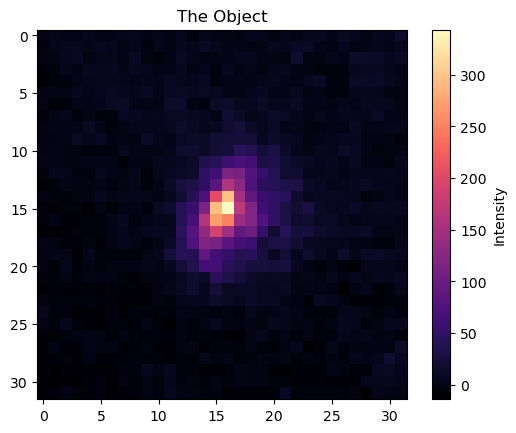

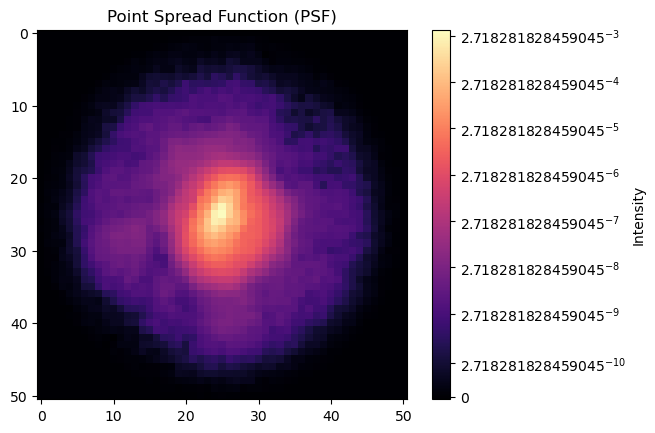

In [9]:
plt.figure(1)
plt.clf()
plt.imshow(obs[0].image, cmap='magma')
plt.colorbar(label='Intensity')
#plt.axvline((psf.shape[0] - 1) * 0.5, color='black', linestyle='--', label='Vertical Center')
#plt.axhline((psf.shape[1] - 1) * 0.5, color='black', linestyle='--', label='Horizontal Center')
plt.title("The Object")
#plt.legend()

plt.figure(2)
plt.clf()
plt.imshow(obs[0].psf.image, norm=norm2, cmap='magma')
plt.colorbar(label='Intensity')
#plt.axvline((psf.shape[0] - 1) * 0.5, color='black', linestyle='--', label='Vertical Center')
#plt.axhline((psf.shape[1] - 1) * 0.5, color='black', linestyle='--', label='Horizontal Center')
plt.title("Point Spread Function (PSF)")
#plt.legend()

In [10]:
resdict

{'noshear': {'model': 'gauss',
  'flags': 0,
  'nfev': 22,
  'ier': 1,
  'errmsg': 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000050',
  'pars': array([-1.75576711e-02,  6.10584728e-02,  9.39871899e-02, -1.42755922e-01,
          6.11799478e-02,  8.70136009e+03]),
  'pars_err': array([1.59231213e-02, 1.38363078e-02, 8.95752497e-02, 8.97746058e-02,
         1.02785485e-02, 3.14468763e+02]),
  'pars_cov0': array([[ 1.03901430e-05, -2.57776682e-06, -1.64836822e-07,
          -3.20798345e-07,  3.40599646e-08,  1.33830949e-03],
         [-2.57776682e-06,  7.84522761e-06, -1.02315350e-07,
           2.72655469e-07, -4.13397437e-08, -1.63362213e-03],
         [-1.64836822e-07, -1.02315350e-07,  3.28807091e-04,
          -1.15791553e-06, -7.40006305e-06, -2.03499992e-02],
         [-3.20798345e-07,  2.72655469e-07, -1.15791553e-06,
           3.30272287e-04, -1.17306472e-05,  7.08042994e-03],
         [ 3.40599646e-08, -4.13397437e-08, -7.40006305e-06